In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, roc_curve, auc
)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("Blues_r")
plt.rcParams.update({'font.size': 10})

In [2]:
df = pd.read_csv('famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 22
target_col = binary_cols[(N - 1) % 8]
print(f"Целевая переменная: {target_col}")

exclude_cols = [target_col, 'cource', 'group', 'stream']
X_raw = df.drop(columns=exclude_cols, errors='ignore')
y_raw = df[target_col].copy()

Целевая переменная: anime


In [3]:
selected_features = [
    'sex', 'age', 'os', 'work_experience', 'ai', 'height',
    'social', 'sport', 'miss', 'foot_size', 'eye_color', 'score', 'hostel'
]

X = X_raw[selected_features].copy()
y = (y_raw == 'Да').astype(int)

label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.85, random_state=42, stratify=y_train_val
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

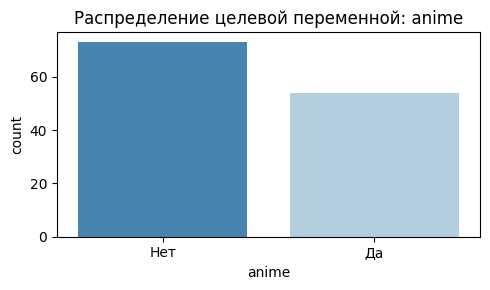

In [16]:
plt.figure(figsize=(5, 3))
sns.countplot(x=target_col, data=df, palette='Blues_r')
plt.title(f'Распределение целевой переменной: {target_col}')
plt.tight_layout()
plt.show()

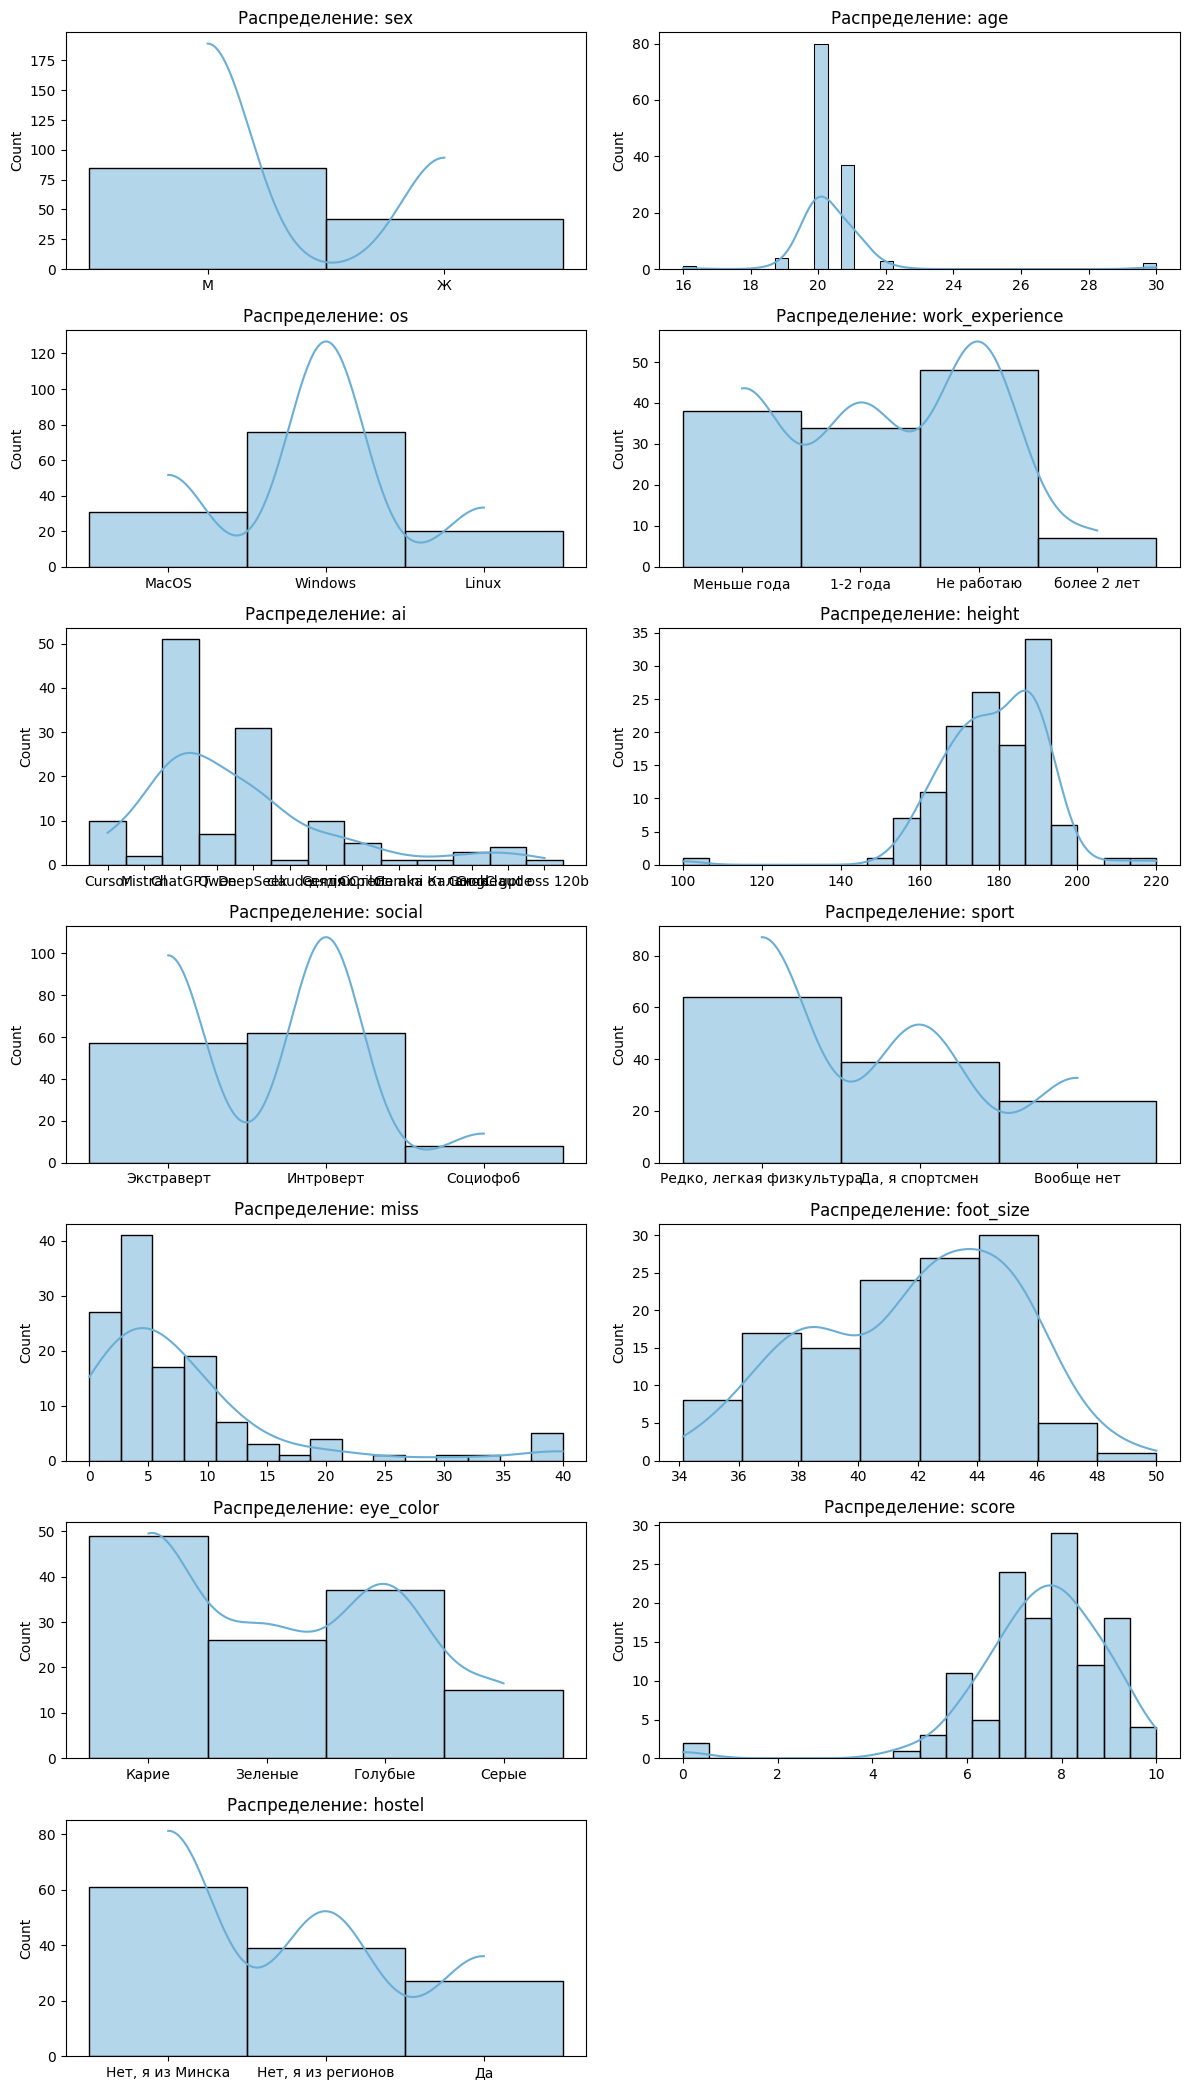

In [17]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else []

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color=sns.color_palette('Blues', 5)[2])
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

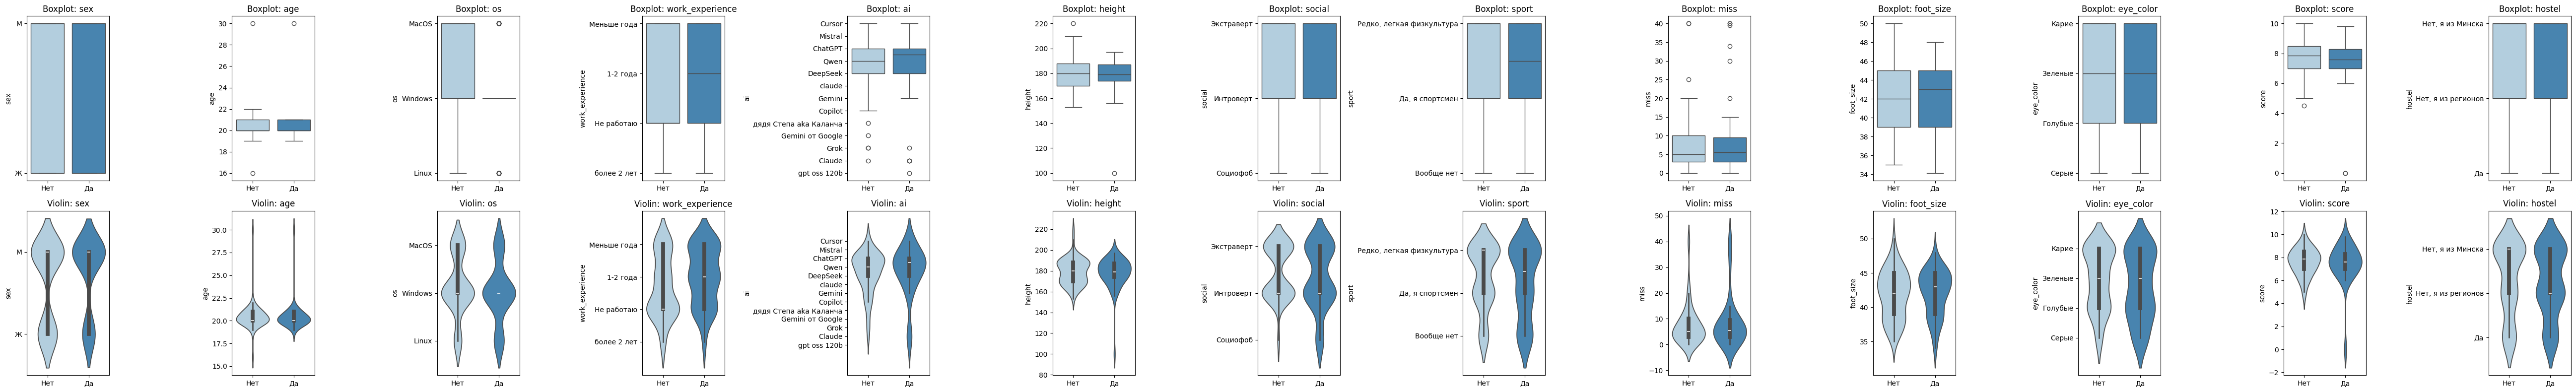

In [18]:
fig, axes = plt.subplots(2, len(numeric_cols), figsize=(4 * len(numeric_cols), 8))

if len(numeric_cols) == 1:
    axes = axes[:, np.newaxis]

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=target_col, y=col, ax=axes[0, i], palette='Blues')
    axes[0, i].set_title(f'Boxplot: {col}')
    axes[0, i].set_xlabel('')

    sns.violinplot(data=df, x=target_col, y=col, ax=axes[1, i], palette='Blues')
    axes[1, i].set_title(f'Violin: {col}')
    axes[1, i].set_xlabel('')

plt.tight_layout()
plt.show()

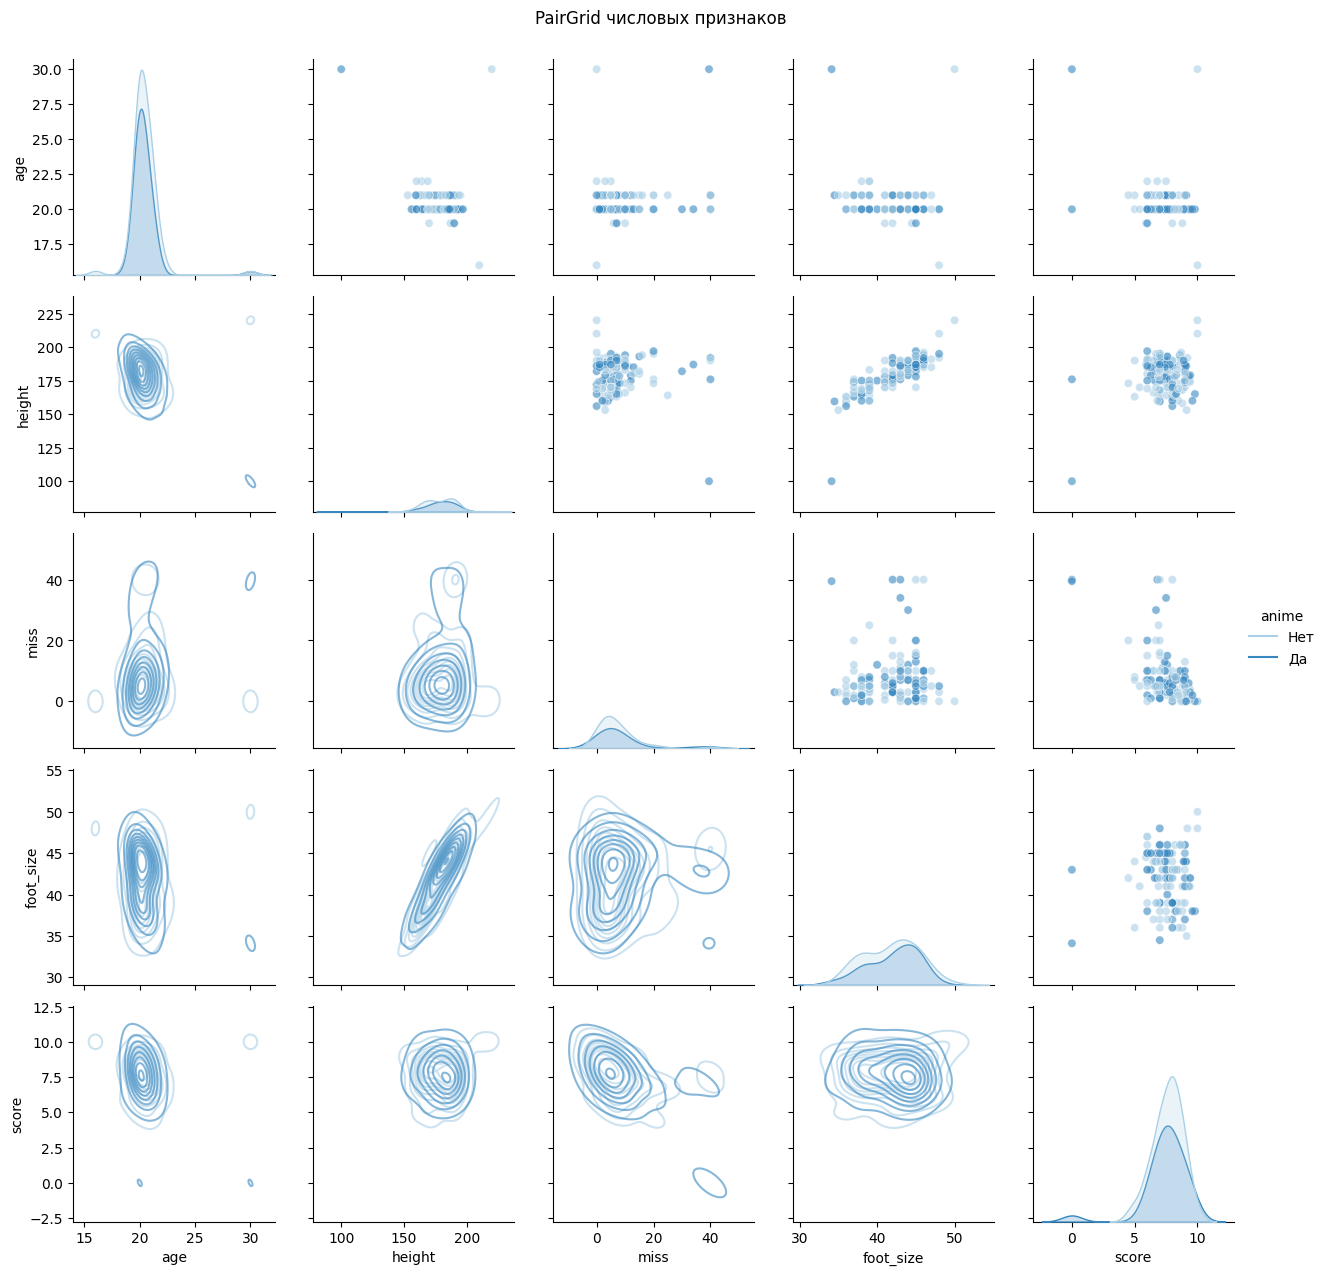

In [20]:
top_numeric = numeric_cols

if len(top_numeric) > 1:
    g = sns.PairGrid(df[top_numeric + [target_col]].dropna(), hue=target_col, palette='Blues')
    g.map_upper(sns.scatterplot, alpha=0.6)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_diag(sns.kdeplot, fill=True)
    g.add_legend(title=target_col)
    plt.suptitle('PairGrid числовых признаков', y=1.02)
    plt.show()

In [4]:
most_common_class = int(y_train.mode()[0])
y_pred_trivial = np.full_like(y_test, most_common_class)

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_pred)
    except:
        roc = np.nan
    cm = confusion_matrix(y_true, y_pred)
    return {'model': model_name, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'roc': roc, 'cm': cm}

results = []
results.append(evaluate_model(y_test, y_pred_trivial, 'Trivial'))

In [5]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {c: np.mean(y == c) for c in self.classes}
        self.class_means = {}
        self.class_vars = {}
        for c in self.classes:
            X_c = X[y == c]
            self.class_means[c] = np.mean(X_c, axis=0)
            self.class_vars[c] = np.var(X_c, axis=0) + 1e-9

    def _gaussian_pdf(self, x, mean, var):
        return np.exp(-0.5 * ((x - mean) ** 2) / var) / np.sqrt(2 * np.pi * var)

    def predict_proba(self, X):
        probas = []
        for x in X:
            class_probs = []
            for c in self.classes:
                prior = self.class_priors[c]
                likelihood = np.prod(self._gaussian_pdf(x, self.class_means[c], self.class_vars[c]))
                class_probs.append(prior * likelihood)
            class_probs = np.array(class_probs)
            probas.append(class_probs / np.sum(class_probs))
        return np.array(probas)

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]

gnb = GaussianNaiveBayes()
gnb.fit(X_train_scaled, y_train)
y_pred_gnb = gnb.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_gnb, 'Naive Bayes'))

In [9]:
import numpy as np
from collections import Counter

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)

    def _euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2, axis=-1))

    def predict(self, X):
        X = np.asarray(X)
        y_pred = []
        for x in X:
            distances = self._euclidean_distance(self.X_train, x)
            k_indices = np.argpartition(distances, self.k - 1)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            y_pred.append(most_common)
        return np.array(y_pred)


k_range = range(1, 21)
best_k, best_f1 = 1, 0
for k in k_range:
    knn = KNearestNeighbors(k=k)
    knn.fit(X_train_scaled, y_train)
    y_val_pred = knn.predict(X_val_scaled)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

knn_best = KNearestNeighbors(k=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_knn, f'k-NN (k={best_k})'))

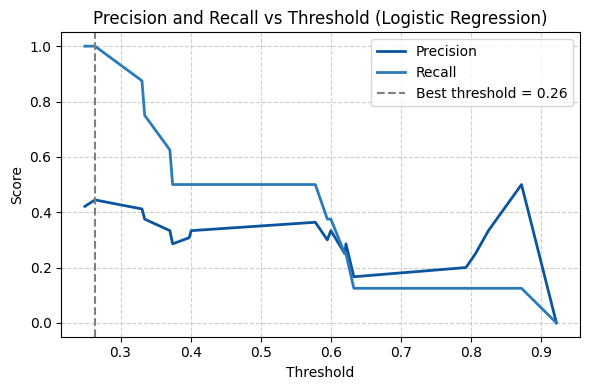

In [10]:
class LogisticRegressionGD:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        self.weights = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            z = X @ self.weights
            h = self._sigmoid(z)
            gradient = X.T @ (h - y) / y.size
            self.weights -= self.lr * gradient

    def predict_proba(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return self._sigmoid(X @ self.weights)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

logreg = LogisticRegressionGD(lr=0.1, epochs=2000)
logreg.fit(X_train_scaled, y_train)

y_val_proba = logreg.predict_proba(X_val_scaled)
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold (Logistic Regression)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

y_pred_logreg = logreg.predict(X_test_scaled, threshold=best_threshold)
results.append(evaluate_model(y_test, y_pred_logreg, 'Logistic Regression'))

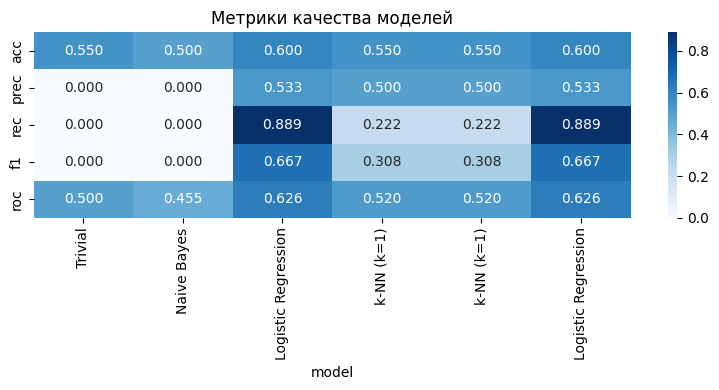

In [11]:
metrics_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'cm'} for r in results])
metrics_df = metrics_df.set_index('model')[['acc', 'prec', 'rec', 'f1', 'roc']]

plt.figure(figsize=(8, 4))
sns.heatmap(metrics_df.T, annot=True, cmap='Blues', cbar=True, fmt='.3f')
plt.title('Метрики качества моделей')
plt.tight_layout()
plt.show()

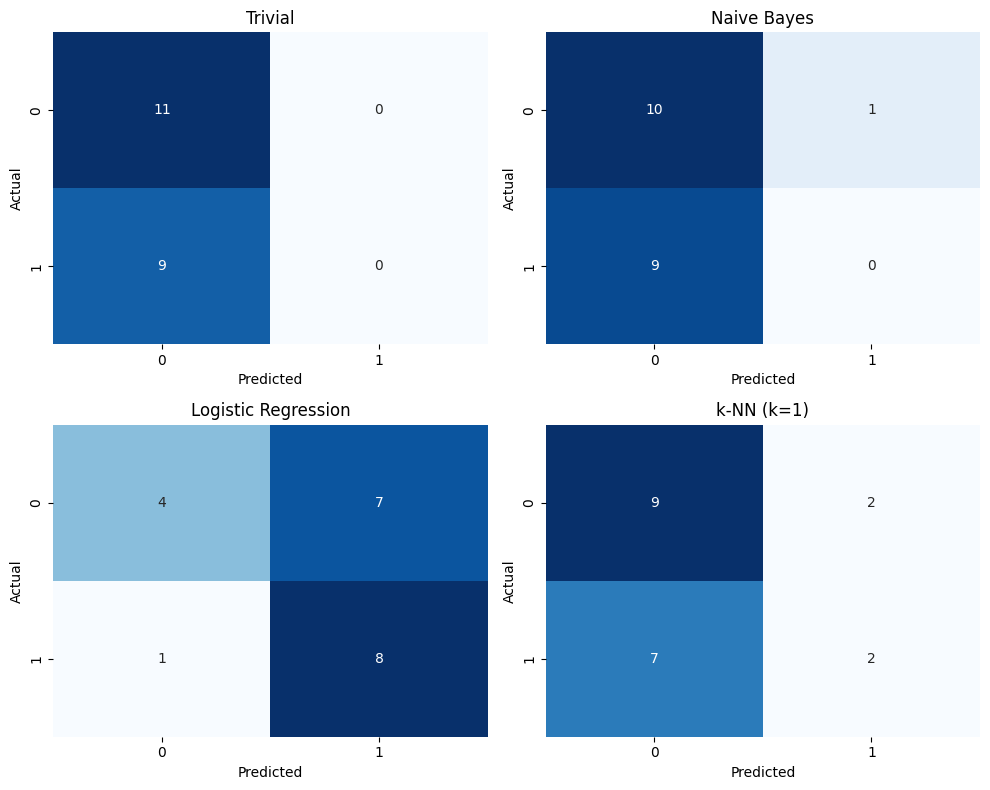

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, res in enumerate(results[:4]):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(res['model'])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()